In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
import zipfile
import os

zip_file_path = '/content/drive/MyDrive/DH 604/datasets_16k.zip'

extract_folder = '/content/DH604/'

os.makedirs(extract_folder, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_folder)

print(f"Files extracted to {extract_folder}")

Files extracted to /content/DH604/


# **Installation**

In [3]:
!pip install audb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.1/241.1 kB 8.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.6/67.6 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.9/150.9 kB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 27.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.4/138.4 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 324.8/324.8 kB 29.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.1/95.1 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 59.3 MB/s eta 0:00:00


In [4]:
!pip install pydub

In [5]:
!pip install opensmile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 996.0/996.0 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 70.3/70.3 kB 5.5 MB/s eta 0:00:00


In [6]:
import os
import time
import datetime
import errno
import random
import copy
import pickle
from tensorflow.keras.optimizers import Adam
import joblib
import collections
from datetime import timedelta, date
from collections import Counter
from tensorflow.keras.models import load_model
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import pyplot
import joblib
import audb
import audiofile
import opensmile

import sklearn
from sklearn.utils import shuffle
from sklearn.datasets import make_classification
from sklearn.model_selection import (
    train_test_split, KFold, StratifiedKFold, ParameterGrid
)
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, log_loss, confusion_matrix,
    classification_report, precision_recall_curve
)
from tensorflow.keras.regularizers import l2
from imblearn.over_sampling import SMOTE
import imblearn

from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import (
    Dense, Activation, LSTM, Bidirectional, RepeatVector, Dropout,
    TimeDistributed, Conv1D, MaxPooling1D, Flatten, ConvLSTM2D
)
from pydub import AudioSegment
from pydub.silence import detect_nonsilent

# Seaborn theme setup
sns.set_theme()

# Inline plotting for Jupyter Notebook
%matplotlib inline


# **Code**

In [7]:
def load_data_from_folds(directory):
    data = {"HS": [], "PD": []}

    # Load each fold
    for fold in range(1, 11):
        fold_path = os.path.join(directory, f"fold{fold}")
        hs_folder = os.path.join(fold_path, "HS")
        pd_folder = os.path.join(fold_path, "PD")

        hs_files = [os.path.join(hs_folder, f) for f in os.listdir(hs_folder) if f.endswith(".wav")]
        pd_files = [os.path.join(pd_folder, f) for f in os.listdir(pd_folder) if f.endswith(".wav")]

        data["HS"].append(hs_files)
        data["PD"].append(pd_files)

    return data

In [8]:
def drop_na(X, y):
    valid_indices = X.dropna(axis=0).index
    X = X.loc[valid_indices]
    y = y.loc[valid_indices]
    return X, y

In [9]:
def process_audio_files(audio_files, n, label):
    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.LowLevelDescriptors,
    )

    X_list = []
    Y_list = []

    for file in audio_files:
        # print(file)
        if file.endswith(".wav"):
            signal, sampling_rate = audiofile.read(file, always_2d=True)
            features = smile.process_signal(signal, sampling_rate).to_numpy()
            segments = [features[i:i+n] for i in range(0, len(features) - n + 1, n)]
            segments = [segment for segment in segments if segment.shape == (n, features.shape[1])]

            if segments:
                X_list.extend(segments)
                Y_list.extend([label] * len(segments))

    X = np.array(X_list, dtype=np.float32)
    Y = np.array(Y_list, dtype=np.int32)
    Y = to_categorical(Y, num_classes=2)

    return X, Y

In [10]:
def balance_classes(X1, Y1, X2, Y2):
    min_samples = min(len(X1), len(X2))

    indices1 = np.random.choice(len(X1), min_samples, replace=False)
    indices2 = np.random.choice(len(X2), min_samples, replace=False)

    X1_balanced, Y1_balanced = X1[indices1], Y1[indices1]
    X2_balanced, Y2_balanced = X2[indices2], Y2[indices2]

    return X1_balanced, Y1_balanced, X2_balanced, Y2_balanced

In [11]:
model_dir = "/content/models"
loss_dir = "/content/loss"
metric_dir = "/content/metric"
scalar_dir = "/content/scale"

os.makedirs(model_dir, exist_ok=True)
os.makedirs(loss_dir, exist_ok=True)
os.makedirs(metric_dir, exist_ok=True)
os.makedirs(scalar_dir, exist_ok=True)

In [22]:
def get_train_test_data(fold_number, data, n_steps_in, n_f, n_ft):
    n = n_steps_in

    # Combine the remaining folds for training
    train_hs = [item for i, item in enumerate(data["HS"]) if i != fold_number-1]
    train_pd = [item for i, item in enumerate(data["PD"]) if i != fold_number-1]

    # Flatten lists for training
    train_hs = [item for sublist in train_hs for item in sublist]
    train_pd = [item for sublist in train_pd for item in sublist]

    # Train -------------------------------------------------------------------------------
    # Process the HS train files
    X1, Y1 = process_audio_files(train_hs, n, label=0)

    # print("Original Shape...")
    # print(X1.shape)
    # print(Y1.shape)


    # Choose n_f elements
    random_indices = np.random.choice(X1.shape[0], n_f, replace=False)
    X1 = X1[random_indices]
    Y1 = Y1[random_indices]


    # Process the PD train files
    X2, Y2 = process_audio_files(train_pd, n, label=1)

    # print("Original Shape...")
    # print(X2.shape)
    # print(Y2.shape)

    # Choose n_f elements
    random_indices = np.random.choice(X2.shape[0], n_f, replace=False)
    X2 = X2[random_indices]
    Y2 = Y2[random_indices]

    X1, Y1, X2, Y2 = balance_classes(X1, Y1, X2, Y2)

    print("Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...")
    print(X1.shape)
    print(Y1.shape)
    print(X2.shape)
    print(Y2.shape)

    X = np.concatenate((X1, X2), axis=0)
    Y = np.concatenate((Y1, Y2), axis=0)

    scaler = MinMaxScaler()
    X_reshaped = X.reshape(-1, X.shape[-1])
    X_scaled = scaler.fit_transform(X_reshaped)
    X_normalized = X_scaled.reshape(X.shape)
    print("Normalised X_train shape")
    print(X_normalized.shape)
    print("Y_train shape")
    print(Y.shape)

    joblib.dump(scaler, f"/content/scale/scaler_fold_{fold_number}.pkl")

    X = X_normalized

    # Shuffle
    idx = np.random.permutation(len(X))
    x_shuffled = []
    y_shuffled = []

    for i in idx:
        x_shuffled.append(X[i])
        y_shuffled.append(Y[i])

    x_a = np.array(x_shuffled)
    print(x_a.shape)
    train_X = x_shuffled
    Y_hot_encoded_train = y_shuffled

    # Test --------------------------------------------------------------------------------------
    # Define test_hs and test_pd for the current fold
    test_hs = data["HS"][fold_number - 1]
    test_pd = data["PD"][fold_number - 1]

    # Process the test files
    X1_t, Y1_t = process_audio_files(test_hs, n, label=0)

    random_indices = np.random.choice(X1_t.shape[0], n_ft, replace=False)
    X1_t = X1_t[random_indices]
    Y1_t = Y1_t[random_indices]

    X2_t, Y2_t = process_audio_files(test_pd, n, label=1)

    random_indices = np.random.choice(X2_t.shape[0], n_ft, replace=False)
    X2_t = X2_t[random_indices]
    Y2_t = Y2_t[random_indices]

    X1_t, Y1_t, X2_t, Y2_t = balance_classes(X1_t, Y1_t, X2_t, Y2_t)
    print("Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...")
    print(X1_t.shape)
    print(Y1_t.shape)
    print(X2_t.shape)
    print(Y2_t.shape)

    X_t = np.concatenate((X1_t, X2_t), axis=0)
    Y_t = np.concatenate((Y1_t, Y2_t), axis=0)

    scalar_file = f"/content/scale/scaler_fold_{fold_number}.pkl"
    scaler_t = joblib.load(scalar_file)

    X_t_reshaped = X_t.reshape(-1, X_t.shape[-1])
    X_t_scaled = scaler_t.transform(X_t_reshaped)
    X_t_normalized = X_t_scaled.reshape(X_t.shape)
    print("Normalised X_test shape")
    print(X_t_normalized.shape)
    print("Y_test shape")
    print(Y_t.shape)

    X_t = X_t_normalized

    # Shuffle
    idx = np.random.permutation(len(X_t))
    x_t_shuffled = []
    y_t_shuffled = []

    for i in idx:
        x_t_shuffled.append(X_t[i])
        y_t_shuffled.append(Y_t[i])

    x_t_a = np.array(x_t_shuffled)
    print(x_t_a.shape)
    test_X = x_t_shuffled
    Y_hot_encoded_test = y_t_shuffled


    # Extra shuffling

    idx = np.random.permutation(len(train_X))

    x_shuffled = []
    y_shuffled = []

    for i in idx:
        x_shuffled.append(train_X[i])
        y_shuffled.append(Y_hot_encoded_train[i])

    x_a = np.array(x_shuffled)
    print(x_a.shape)

    train_X = x_shuffled
    Y_hot_encoded_train = y_shuffled

    # --------------------

    idx = np.random.permutation(len(test_X))

    x_shuffled = []
    y_shuffled = []

    for i in idx:
        x_shuffled.append(test_X[i])
        y_shuffled.append(Y_hot_encoded_test[i])

    x_a = np.array(x_shuffled)
    print(x_a.shape)

    test_X = x_shuffled
    Y_hot_encoded_test = y_shuffled

    # -------------------

    print("Train and test shapes...")
    print(len(train_X))
    print(len(Y_hot_encoded_train))
    print(len(test_X))
    print(len(Y_hot_encoded_test))

    return train_X, test_X, Y_hot_encoded_train, Y_hot_encoded_test

In [13]:
negative_slope = 0.01
activation_lstm = tf.keras.layers.LeakyReLU(negative_slope = negative_slope)
activation_dense = 'softmax'

In [14]:
def vanilla(n_steps_in,n_steps_out,n_features_in, n_features_out, hidden_layers):
  model = Sequential()
  model.add(LSTM(hidden_layers, activation= activation_lstm, input_shape=(n_steps_in, n_features_in), kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.3))
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

In [15]:
def bidirectional(n_steps_in,n_steps_out,n_features_in, n_features_out, hidden_layers):
  model = Sequential()
  model.add(Bidirectional(LSTM(hidden_layers, activation=None, kernel_regularizer=l2(0.01), input_shape=(n_steps_in, n_features_in))))
  model.add(Dropout(0.3))
  model.add(tf.keras.layers.LeakyReLU(negative_slope=0.01))    #added to incorporate leaky relu
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

In [16]:
def cnn_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq, hidden_layers):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(filters=32, kernel_size=5, activation=activation_lstm), input_shape=(n_seq, int(n_steps_in/n_seq), n_features_in)))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(hidden_layers, activation=activation_lstm, kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.3))
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

In [17]:
def conv_lstm(n_steps_in,n_steps_out,n_features_in, n_features_out, n_seq):
  model = Sequential()
  model.add(ConvLSTM2D(filters=32, kernel_size=(1,2), activation=activation_lstm,
                         input_shape=(n_seq, 1, int(n_steps_in/n_seq), n_features_in), kernel_regularizer=l2(0.01)))
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(n_features_out, activation = activation_dense))
  return model

In [18]:
def create_model(model_type, x_train, x_test, y_train, y_test):
    if model_type == 'vanilla':
      univariate = False
      n_steps_in = 30
      n_seq = 1
      n_steps_out = 2
      n_features_in = 65
      n_features_out = 2
      hidden_layers = 32
      No_exp = 1

      model = vanilla(n_steps_in, n_steps_out, n_features_in, n_features_out, hidden_layers)

      x_train, y_train = np.asarray(x_train), np.asarray(y_train)
      x_test, y_test = np.asarray(x_test), np.asarray(y_test)
      x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
      x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))


    elif model_type == 'bidirectional':
      univariate = False
      n_steps_in = 30
      n_seq = 1
      n_steps_out = 2
      n_features_in = 65
      n_features_out = 2
      hidden_layers = 32
      No_exp = 1

      model = bidirectional(n_steps_in, n_steps_out, n_features_in, n_features_out, hidden_layers)

      x_train, y_train = np.asarray(x_train), np.asarray(y_train)
      x_test, y_test = np.asarray(x_test), np.asarray(y_test)
      x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], n_features_in))
      x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], n_features_in))

    elif model_type == 'cnn-lstm':
      univariate = False
      n_steps_in = 30
      n_seq = 1
      n_steps_out = 2
      n_features_in = 65
      n_features_out = 2
      hidden_layers = 32
      No_exp = 1

      model = cnn_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out, n_seq, hidden_layers)

      x_train, y_train = np.asarray(x_train), np.asarray(y_train)
      x_test, y_test = np.asarray(x_test), np.asarray(y_test)
      x_train = x_train.reshape((x_train.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))
      x_test = x_test.reshape((x_test.shape[0], n_seq, int(n_steps_in/n_seq), n_features_in))


    elif model_type == 'conv-lstm':
      univariate = False
      n_steps_in = 30
      n_seq = 5
      n_steps_out = 2
      n_features_in = 65
      n_features_out = 2
      hidden_layers = 32
      No_exp = 1

      model = conv_lstm(n_steps_in, n_steps_out, n_features_in, n_features_out, n_seq)

      x_train, y_train = np.asarray(x_train), np.asarray(y_train)
      x_test, y_test = np.asarray(x_test), np.asarray(y_test)
      x_train = x_train.reshape((x_train.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))
      x_test = x_test.reshape((x_test.shape[0], n_seq, 1, int(n_steps_in/n_seq), n_features_in))

    else:
        raise ValueError("Invalid model type.")
    return model, x_train, x_test, y_train, y_test

In [19]:
def MODEL_LSTM(model_name, method, x_train, x_test, y_train, y_test, Num_Exp, fold_number):
    train_f1, test_f1 = np.zeros(Num_Exp), np.zeros(Num_Exp)
    roc_auc_train_values, roc_auc_test_values = np.zeros(Num_Exp), np.zeros(Num_Exp)

    # Model
    model, x_train, x_test, y_train, y_test = create_model(model_name, x_train, x_test, y_train, y_test)
    model.summary()

    if model_name == 'vanilla':
        lr_adam = 0.00005
        batch_size = 256
        Epochs = 250
    elif model_name == 'bidirectional':
        lr_adam = 0.0001
        batch_size = 256
        Epochs = 300
    elif model_name == 'cnn-lstm':
        lr_adam = 0.0001
        batch_size = 128
        Epochs = 300
    elif model_name == 'conv-lstm':
        lr_adam = 0.0001
        batch_size = 128
        Epochs = 150

    optimizer = Adam(learning_rate = lr_adam)
    label_smoothing = 0.05
    loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = label_smoothing)


    act_test = y_test.argmax(axis=1)
    act_train = y_train.argmax(axis=1)

    start_time = time.time()
    Best_f1, Best_Predict_Test = 0, None

    all_report_train, all_report_test = {}, {}
    train_loss_per_epoch, test_loss_per_epoch = [], []
    metrics_list = []

    for run in range(Num_Exp):
        print(f"Experiment {run + 1}/{Num_Exp} in progress")

        model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])
        history = model.fit(x_train, y_train, epochs=Epochs, batch_size=batch_size, verbose=0, shuffle=False, validation_data=(x_test, y_test))

        # Append the loss for each epoch
        train_loss_per_epoch.append(history.history['loss'])
        test_loss_per_epoch.append(history.history['val_loss'])

        y_predicttrain, y_predicttest = model.predict(x_train), model.predict(x_test)
        pred_train, pred_test = y_predicttrain.argmax(axis=1), y_predicttest.argmax(axis=1)

        report_train = classification_report(act_train, pred_train, labels=[0, 1], output_dict=True)
        report_test = classification_report(act_test, pred_test, labels=[0, 1], output_dict=True)

        all_report_train[run], all_report_test[run] = report_train, report_test
        train_f1[run], test_f1[run] = report_train['1']['f1-score'], report_test['1']['f1-score']
        roc_auc_train_values[run] = roc_auc_score(y_train[:, 1], y_predicttrain[:, 1])
        roc_auc_test_values[run] = roc_auc_score(y_test[:, 1], y_predicttest[:, 1])

        print(f"Train Acc: {report_train['accuracy']:.4f}, Val Acc: {report_test['accuracy']:.4f}")
        print(f"Train Recall: {report_train['1']['recall']:.4f}, Val Recall: {report_test['1']['recall']:.4f}")
        print(f"Train Precision: {report_train['1']['precision']:.4f}, Val Precision: {report_test['1']['precision']:.4f}")
        print(f"Train F1: {train_f1[run]:.4f}, Val F1: {test_f1[run]:.4f}")
        print(f"Train ROC AUC: {roc_auc_train_values[run]:.4f}, Val ROC AUC: {roc_auc_test_values[run]:.4f}")

        metrics_list.append({'Train Accuracy': report_train['accuracy'],
                            'Test Accuracy': report_test['accuracy'],
                            'Train Recall': report_train['1']['recall'],
                            'Test Recall': report_test['1']['recall'],
                            'Train Precision': report_train['1']['precision'],
                            'Test Precision': report_test['1']['precision'],
                            'Train F1': train_f1[run],
                            'Test F1': test_f1[run],
                            'Train ROC AUC': roc_auc_train_values[run],
                            'Test ROC AUC': roc_auc_test_values[run]
                            })

        if test_f1[run] > Best_f1:
            Best_f1, Best_Predict_Test = test_f1[run], y_predicttest



    model.save(f"/content/models/model_{model_name}_{method}_{fold_number}.h5")
    elapsed_time = time.time() - start_time

    print(f"\nTotal Time for {Num_Exp} Experiments: {elapsed_time:.2f} sec")
    print(f"Mean Val F1: {np.mean(test_f1):.4f}, Mean Val ROC AUC: {np.mean(roc_auc_test_values):.4f}")

    # fpr, tpr, _ = roc_curve(y_test[:, 1], Best_Predict_Test[:, 1])
    # plt.figure(figsize=(8, 6))
    # plt.plot(fpr, tpr, label=f'ROC AUC = {np.mean(roc_auc_test_values):.4f}', color='darkorange')
    # plt.plot([0, 1], [0, 1], linestyle='--', color='navy')
    # plt.xlabel('False Positive Rate')
    # plt.ylabel('True Positive Rate')
    # plt.title(f'ROC Curve ({model_name}) ({fold_number})')
    # plt.legend()
    # plt.show()

    # Compute the mean of losses per epoch across all experiments
    train_loss_mean = np.mean(train_loss_per_epoch, axis=0)
    test_loss_mean = np.mean(test_loss_per_epoch, axis=0)

    # Plot Train vs Test Loss
    plt.figure(figsize=(8, 6))
    plt.plot(range(1, Epochs+1), train_loss_mean, label='Train Loss', color='blue')
    plt.plot(range(1, Epochs+1), test_loss_mean, label='Val Loss', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title(f'Train vs Val Loss ({model_name}) ({fold_number})')
    plt.legend()
    plt.show()

    num_epochs_recorded = len(train_loss_per_epoch)

    epochs = list(range(1, Epochs + 1))
    all_train_losses = [loss for sublist in train_loss_per_epoch for loss in sublist]
    all_test_losses = [loss for sublist in test_loss_per_epoch for loss in sublist]


    loss_df = pd.DataFrame({
        'Epoch': epochs * Num_Exp,
        'Train Loss': all_train_losses,
        'Test Loss': all_test_losses
    })

    csv_filename = f"/content/loss/loss_per_epoch_{model_name}_{method}_{fold_number}.csv"
    loss_df.to_csv(csv_filename, index=False)
    print(f"Saved per-epoch loss to: {csv_filename}")

    metrics_df = pd.DataFrame(metrics_list)
    metrics_filename = f"/content/metric/metrics_{model_name}_{method}_{fold_number}.csv"
    metrics_df.to_csv(metrics_filename, index=False)
    print(f"Saved metrics to: {metrics_filename}")

In [20]:
def main(directory, model_type):
    data = load_data_from_folds(directory)

    for fold_number in range(1, 11):
        print(f"Evaluating fold {fold_number}...")

        if fold_number == 5:
          n_steps_in = 30
          n_f = 3000
          n_ft = 100
          Num_Exp = 1
        else:
          n_steps_in = 30
          n_f = 3000
          n_ft = 300
          Num_Exp = 1


        method = 'k_fold'

        x_train, x_test, y_train, y_test = get_train_test_data(fold_number, data, n_steps_in, n_f, n_ft)


        MODEL_LSTM(model_type, method, x_train, x_test, y_train, y_test, Num_Exp, fold_number)

Evaluating fold 1...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_7 (LSTM)                   │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Train Acc: 0.9880, Val Acc: 0.8650
Train Recall: 0.9897, Val Recall: 0.7933
Train Precision: 0.9864, Val Precision: 0.9261
Train F1: 0.9880, Val F1: 0.8546
Train ROC AUC: 0.9982, Val ROC AUC: 0.9311

Total Time for 1 Experiments: 323.77 sec
Mean Val F1: 0.8546, Mean Val ROC AUC: 0.9311


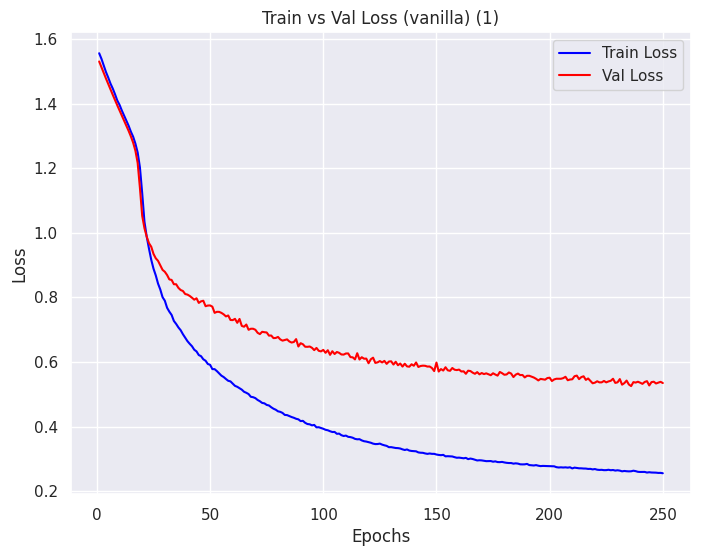

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_1.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_1.csv
Evaluating fold 2...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_8 (LSTM)                   │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Train Acc: 0.9822, Val Acc: 0.9833
Train Recall: 0.9820, Val Recall: 0.9733
Train Precision: 0.9823, Val Precision: 0.9932
Train F1: 0.9822, Val F1: 0.9832
Train ROC AUC: 0.9978, Val ROC AUC: 0.9986

Total Time for 1 Experiments: 330.44 sec
Mean Val F1: 0.9832, Mean Val ROC AUC: 0.9986


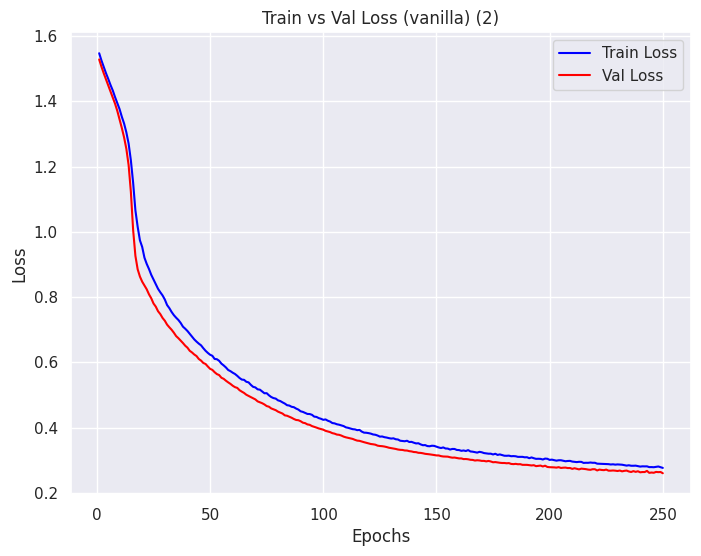

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_2.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_2.csv
Evaluating fold 3...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Train Acc: 0.9818, Val Acc: 0.9967
Train Recall: 0.9890, Val Recall: 0.9933
Train Precision: 0.9750, Val Precision: 1.0000
Train F1: 0.9820, Val F1: 0.9967
Train ROC AUC: 0.9973, Val ROC AUC: 0.9999

Total Time for 1 Experiments: 331.74 sec
Mean Val F1: 0.9967, Mean Val ROC AUC: 0.9999


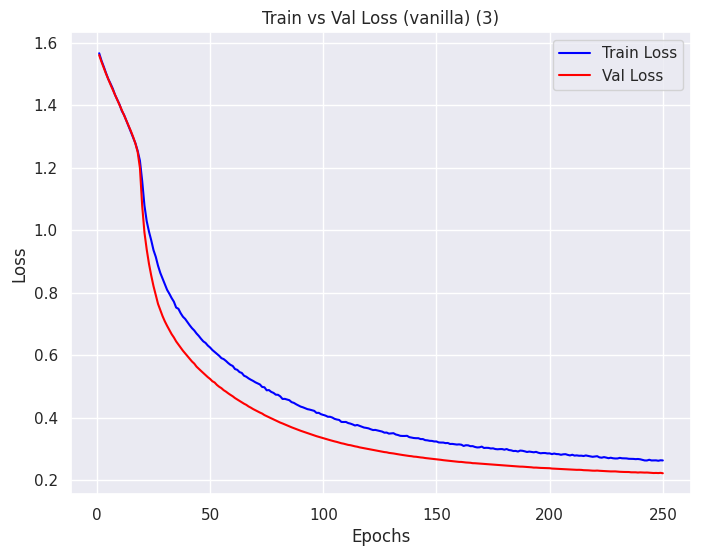

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_3.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_3.csv
Evaluating fold 4...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Train Acc: 0.9845, Val Acc: 0.9567
Train Recall: 0.9897, Val Recall: 0.9633
Train Precision: 0.9795, Val Precision: 0.9507
Train F1: 0.9846, Val F1: 0.9570
Train ROC AUC: 0.9981, Val ROC AUC: 0.9879

Total Time for 1 Experiments: 320.19 sec
Mean Val F1: 0.9570, Mean Val ROC AUC: 0.9879


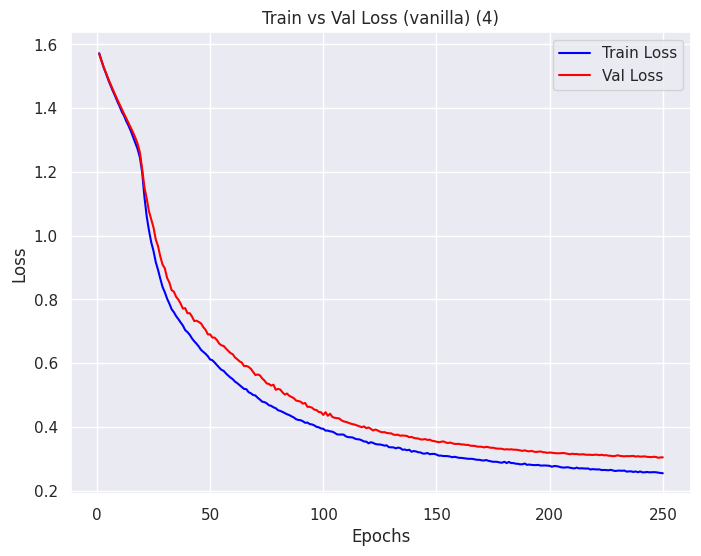

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_4.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_4.csv
Evaluating fold 5...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(100, 30, 65)
(100, 2)
(100, 30, 65)
(100, 2)
Normalised X_test shape
(200, 30, 65)
Y_test shape
(200, 2)
(200, 30, 65)
(6000, 30, 65)
(200, 30, 65)
Train and test shapes...
6000
6000
200
200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_11 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Train Acc: 0.9838, Val Acc: 0.9500
Train Recall: 0.9880, Val Recall: 0.9100
Train Precision: 0.9798, Val Precision: 0.9891
Train F1: 0.9839, Val F1: 0.9479
Train ROC AUC: 0.9976, Val ROC AUC: 0.9936

Total Time for 1 Experiments: 317.96 sec
Mean Val F1: 0.9479, Mean Val ROC AUC: 0.9936


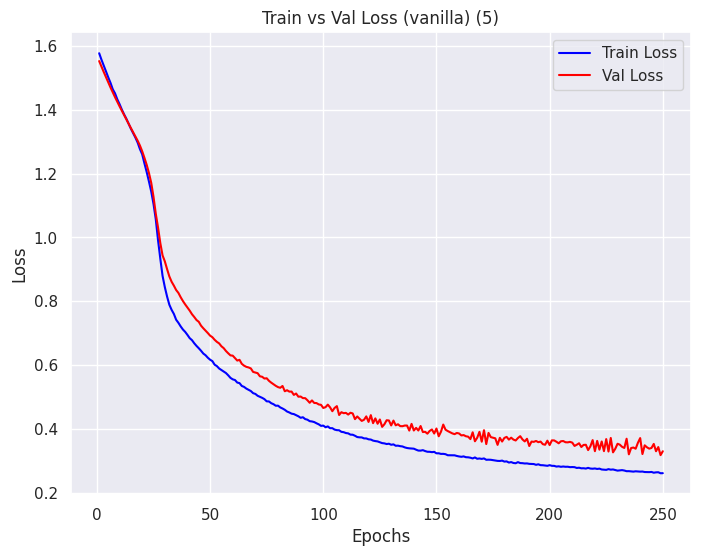

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_5.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_5.csv
Evaluating fold 6...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_12 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_12 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Train Acc: 0.9790, Val Acc: 0.9983
Train Recall: 0.9780, Val Recall: 1.0000
Train Precision: 0.9800, Val Precision: 0.9967
Train F1: 0.9790, Val F1: 0.9983
Train ROC AUC: 0.9973, Val ROC AUC: 1.0000

Total Time for 1 Experiments: 321.62 sec
Mean Val F1: 0.9983, Mean Val ROC AUC: 1.0000


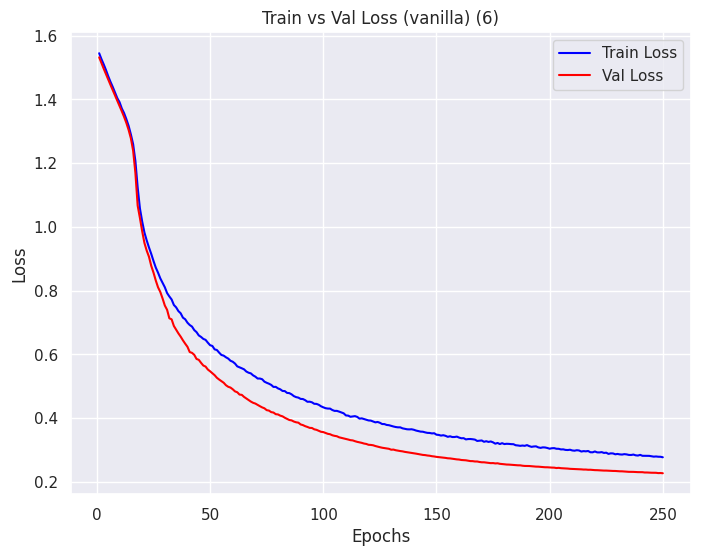

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_6.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_6.csv
Evaluating fold 7...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_13 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_13 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Train Acc: 0.9843, Val Acc: 0.9833
Train Recall: 0.9900, Val Recall: 0.9733
Train Precision: 0.9789, Val Precision: 0.9932
Train F1: 0.9844, Val F1: 0.9832
Train ROC AUC: 0.9984, Val ROC AUC: 0.9994

Total Time for 1 Experiments: 320.43 sec
Mean Val F1: 0.9832, Mean Val ROC AUC: 0.9994


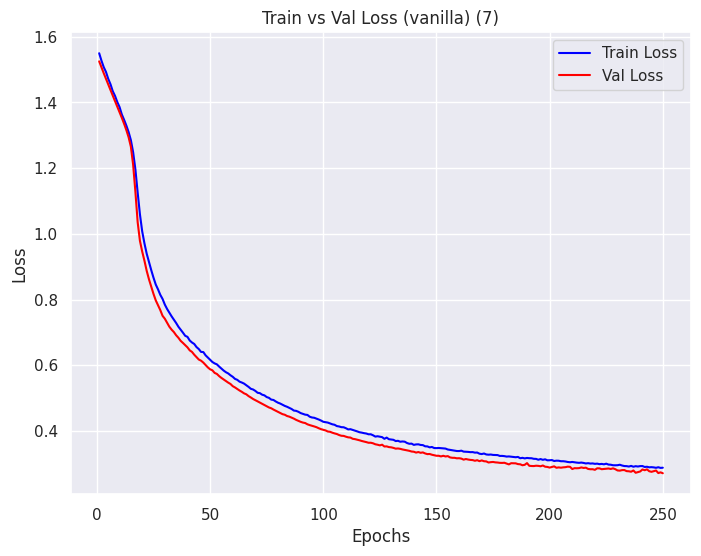

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_7.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_7.csv
Evaluating fold 8...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_14"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_14 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Train Acc: 0.9868, Val Acc: 0.8400
Train Recall: 0.9917, Val Recall: 0.6867
Train Precision: 0.9822, Val Precision: 0.9904
Train F1: 0.9869, Val F1: 0.8110
Train ROC AUC: 0.9983, Val ROC AUC: 0.9884

Total Time for 1 Experiments: 329.54 sec
Mean Val F1: 0.8110, Mean Val ROC AUC: 0.9884


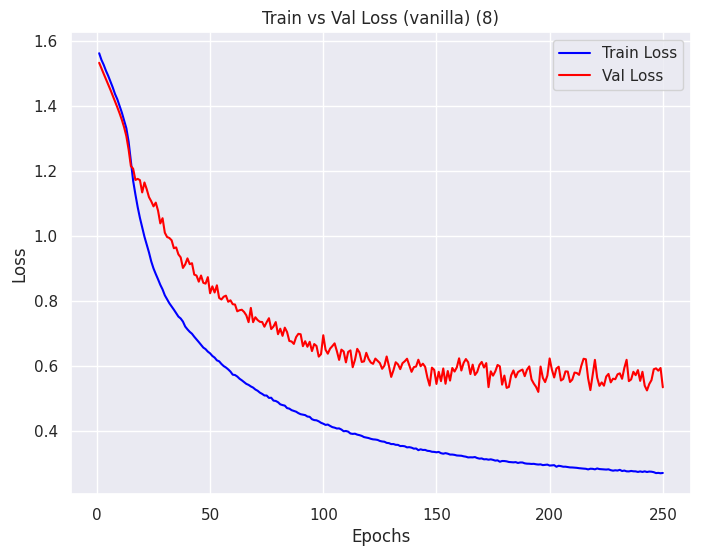

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_8.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_8.csv
Evaluating fold 9...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_15 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


Train Acc: 0.9867, Val Acc: 0.8883
Train Recall: 0.9830, Val Recall: 0.9933
Train Precision: 0.9903, Val Precision: 0.8209
Train F1: 0.9866, Val F1: 0.8989
Train ROC AUC: 0.9990, Val ROC AUC: 0.9634

Total Time for 1 Experiments: 327.87 sec
Mean Val F1: 0.8989, Mean Val ROC AUC: 0.9634


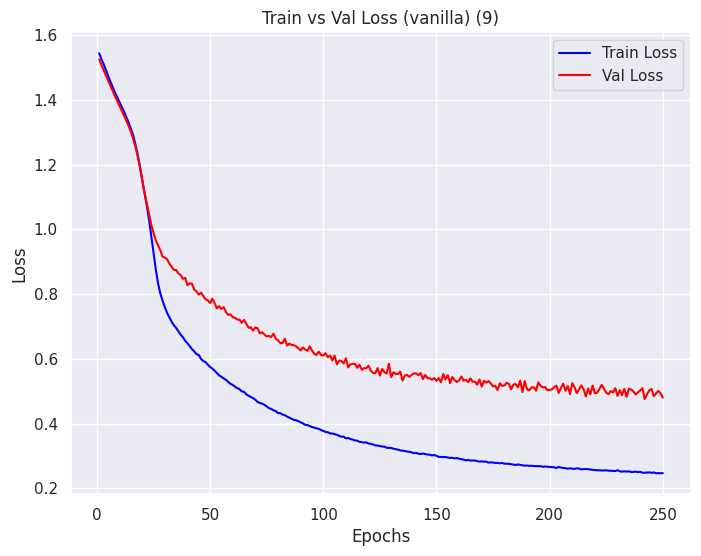

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_9.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_9.csv
Evaluating fold 10...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_16 (LSTM)                  │ (None, 32)             │        12,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,610 (49.26 KB)

 Trainable params: 12,610 (49.26 KB)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


Train Acc: 0.9788, Val Acc: 0.9900
Train Recall: 0.9863, Val Recall: 1.0000
Train Precision: 0.9718, Val Precision: 0.9804
Train F1: 0.9790, Val F1: 0.9901
Train ROC AUC: 0.9966, Val ROC AUC: 0.9995

Total Time for 1 Experiments: 328.13 sec
Mean Val F1: 0.9901, Mean Val ROC AUC: 0.9995


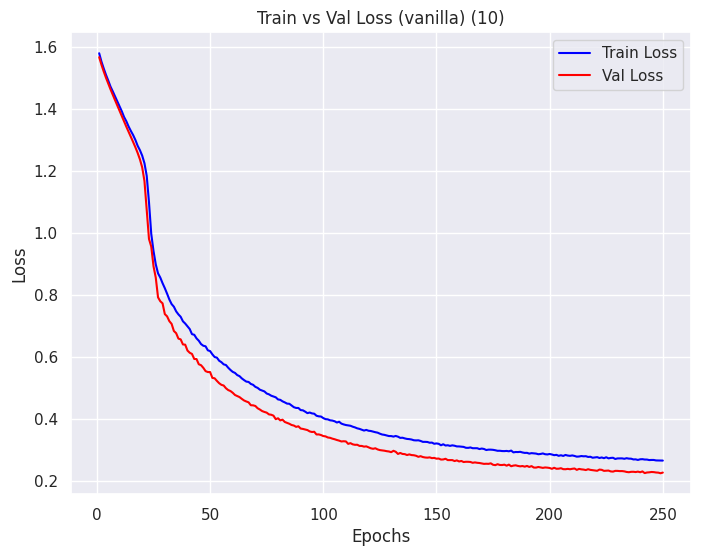

Saved per-epoch loss to: /content/loss/loss_per_epoch_vanilla_k_fold_10.csv
Saved metrics to: /content/metric/metrics_vanilla_k_fold_10.csv


In [ ]:
main(directory = '/content/DH604/datasets_16k', model_type = 'vanilla')

Evaluating fold 1...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Train Acc: 0.9902, Val Acc: 0.8750
Train Recall: 0.9967, Val Recall: 0.8467
Train Precision: 0.9839, Val Precision: 0.8975
Train F1: 0.9902, Val F1: 0.8714
Train ROC AUC: 0.9994, Val ROC AUC: 0.9489

Total Time for 1 Experiments: 724.42 sec
Mean Val F1: 0.8714, Mean Val ROC AUC: 0.9489


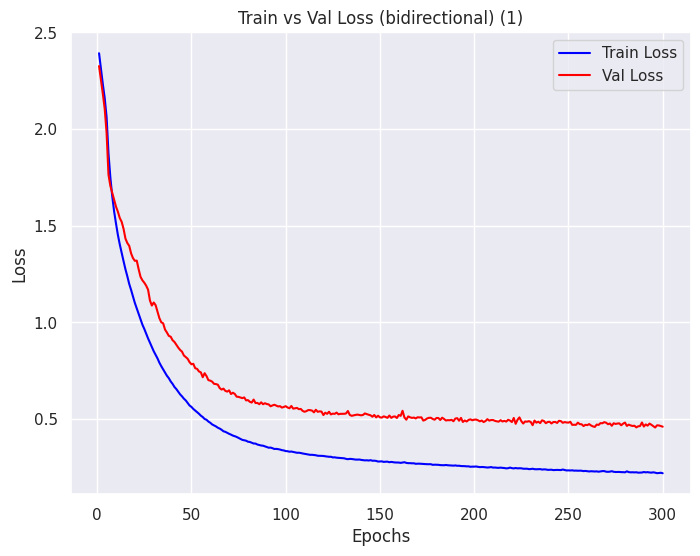

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_1.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_1.csv
Evaluating fold 2...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_1 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step


Train Acc: 0.9802, Val Acc: 0.9933
Train Recall: 0.9657, Val Recall: 0.9900
Train Precision: 0.9945, Val Precision: 0.9966
Train F1: 0.9799, Val F1: 0.9933
Train ROC AUC: 0.9988, Val ROC AUC: 0.9991

Total Time for 1 Experiments: 735.47 sec
Mean Val F1: 0.9933, Mean Val ROC AUC: 0.9991


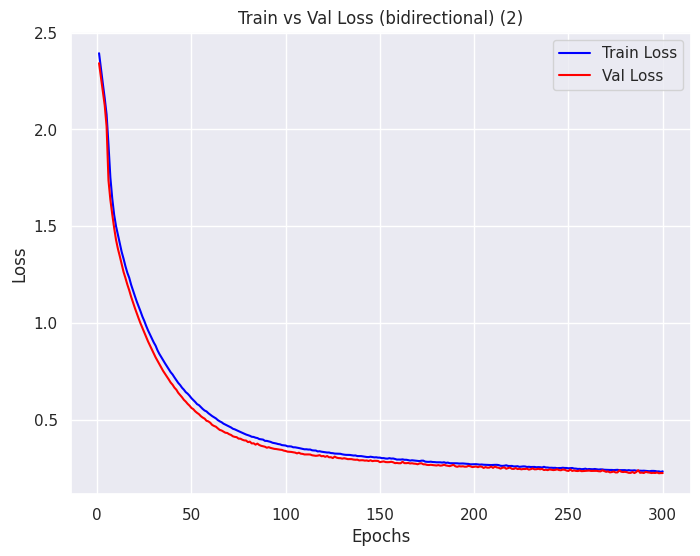

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_2.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_2.csv
Evaluating fold 3...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_19"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_2 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Train Acc: 0.9813, Val Acc: 0.9950
Train Recall: 0.9943, Val Recall: 0.9900
Train Precision: 0.9691, Val Precision: 1.0000
Train F1: 0.9816, Val F1: 0.9950
Train ROC AUC: 0.9981, Val ROC AUC: 1.0000

Total Time for 1 Experiments: 745.24 sec
Mean Val F1: 0.9950, Mean Val ROC AUC: 1.0000


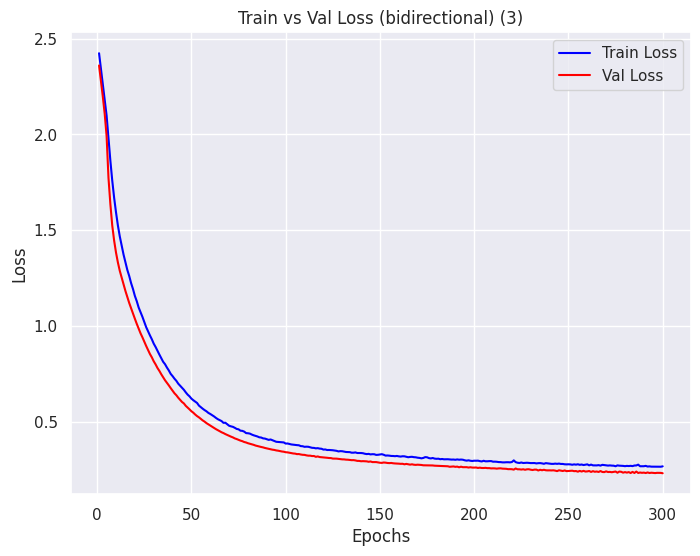

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_3.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_3.csv
Evaluating fold 4...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_3 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


Train Acc: 0.9800, Val Acc: 0.9100
Train Recall: 0.9707, Val Recall: 0.8600
Train Precision: 0.9891, Val Precision: 0.9556
Train F1: 0.9798, Val F1: 0.9053
Train ROC AUC: 0.9977, Val ROC AUC: 0.9891

Total Time for 1 Experiments: 734.84 sec
Mean Val F1: 0.9053, Mean Val ROC AUC: 0.9891


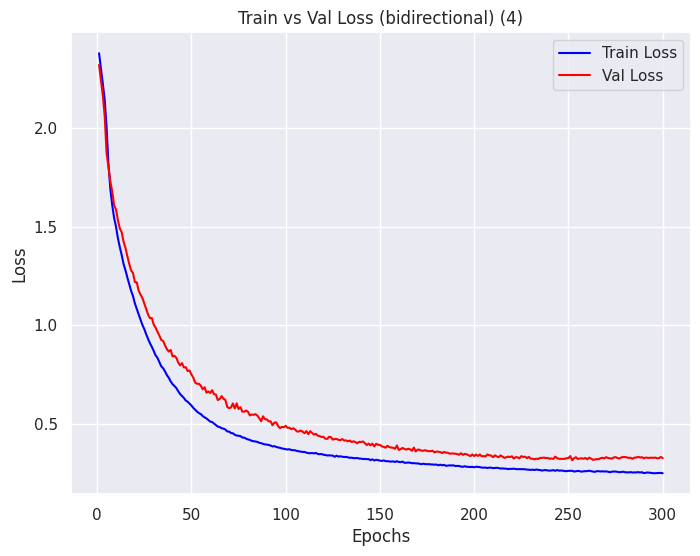

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_4.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_4.csv
Evaluating fold 5...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(100, 30, 65)
(100, 2)
(100, 30, 65)
(100, 2)
Normalised X_test shape
(200, 30, 65)
Y_test shape
(200, 2)
(200, 30, 65)
(6000, 30, 65)
(200, 30, 65)
Train and test shapes...
6000
6000
200
200


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_21"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


Train Acc: 0.9845, Val Acc: 0.9300
Train Recall: 0.9797, Val Recall: 0.8600
Train Precision: 0.9892, Val Precision: 1.0000
Train F1: 0.9844, Val F1: 0.9247
Train ROC AUC: 0.9984, Val ROC AUC: 0.9939

Total Time for 1 Experiments: 728.55 sec
Mean Val F1: 0.9247, Mean Val ROC AUC: 0.9939


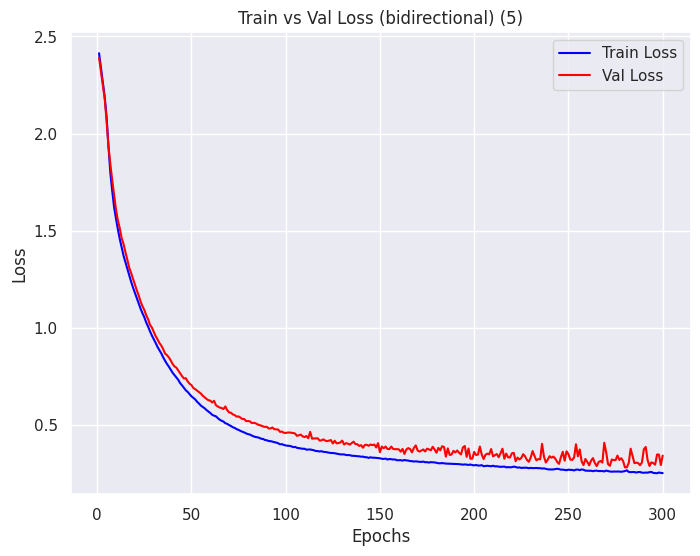

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_5.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_5.csv
Evaluating fold 6...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_22"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_5 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Train Acc: 0.9845, Val Acc: 0.9983
Train Recall: 0.9873, Val Recall: 1.0000
Train Precision: 0.9818, Val Precision: 0.9967
Train F1: 0.9845, Val F1: 0.9983
Train ROC AUC: 0.9985, Val ROC AUC: 1.0000

Total Time for 1 Experiments: 731.68 sec
Mean Val F1: 0.9983, Mean Val ROC AUC: 1.0000


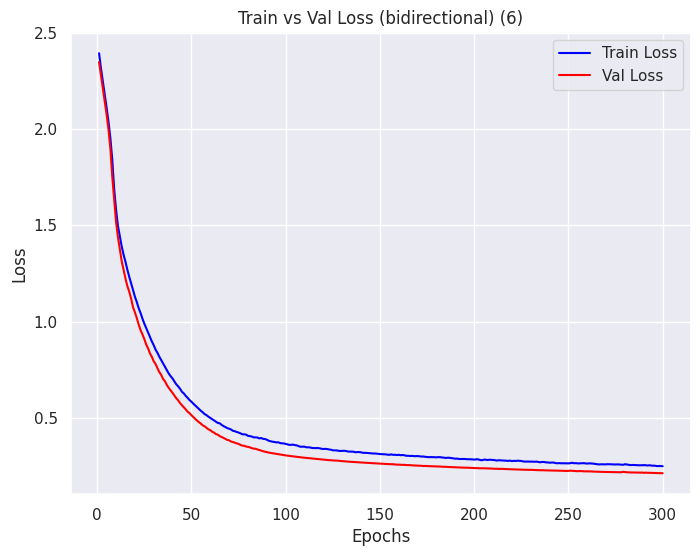

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_6.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_6.csv
Evaluating fold 7...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_23"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_6 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 3s 12ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Train Acc: 0.9890, Val Acc: 0.9750
Train Recall: 0.9867, Val Recall: 0.9567
Train Precision: 0.9913, Val Precision: 0.9931
Train F1: 0.9890, Val F1: 0.9745
Train ROC AUC: 0.9986, Val ROC AUC: 0.9994

Total Time for 1 Experiments: 761.81 sec
Mean Val F1: 0.9745, Mean Val ROC AUC: 0.9994


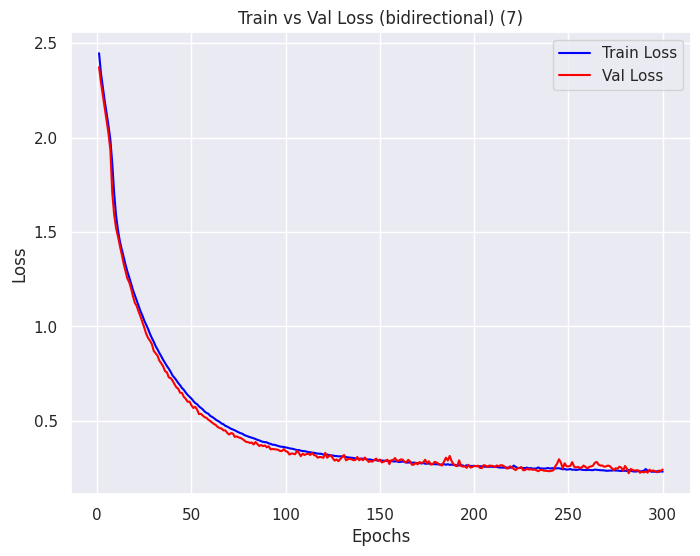

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_7.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_7.csv
Evaluating fold 8...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_24"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_7 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_12 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


Train Acc: 0.9890, Val Acc: 0.8533
Train Recall: 0.9920, Val Recall: 0.7067
Train Precision: 0.9861, Val Precision: 1.0000
Train F1: 0.9890, Val F1: 0.8281
Train ROC AUC: 0.9987, Val ROC AUC: 0.9807

Total Time for 1 Experiments: 762.67 sec
Mean Val F1: 0.8281, Mean Val ROC AUC: 0.9807


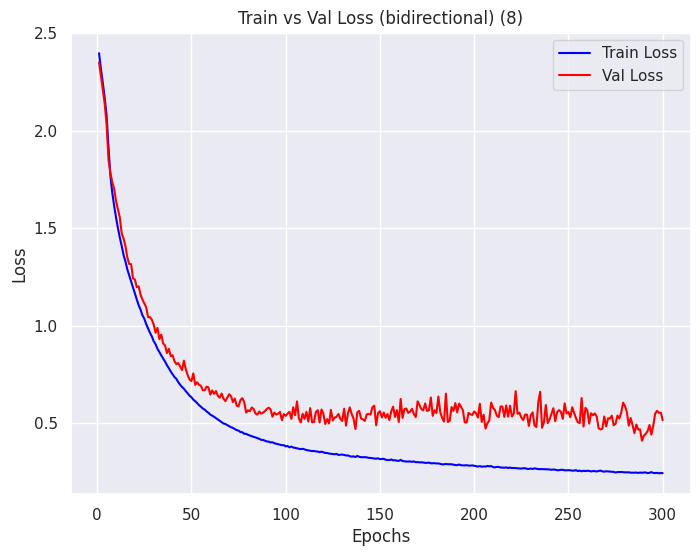

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_8.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_8.csv
Evaluating fold 9...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_8 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_13 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


Train Acc: 0.9922, Val Acc: 0.8850
Train Recall: 0.9917, Val Recall: 0.9967
Train Precision: 0.9927, Val Precision: 0.8147
Train F1: 0.9922, Val F1: 0.8966
Train ROC AUC: 0.9998, Val ROC AUC: 0.9517

Total Time for 1 Experiments: 747.72 sec
Mean Val F1: 0.8966, Mean Val ROC AUC: 0.9517


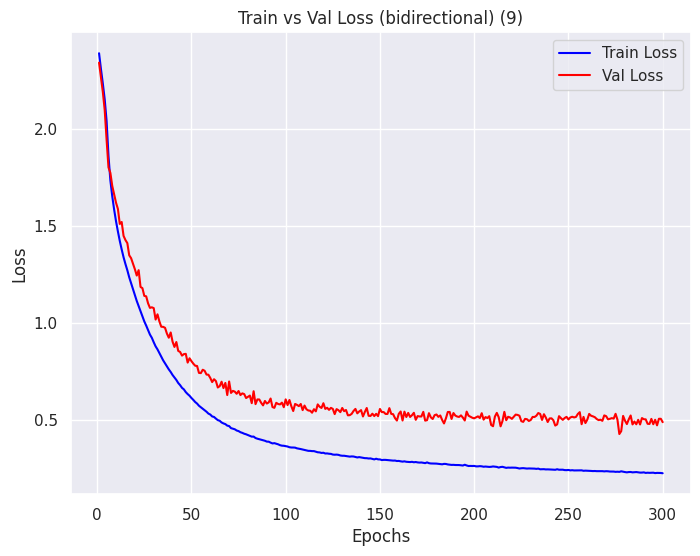

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_9.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_9.csv
Evaluating fold 10...
Training shapes for HS_xtrain, HS_ytrain, PD_xtrain, PD_ytrain...
(3000, 30, 65)
(3000, 2)
(3000, 30, 65)
(3000, 2)
Normalised X_train shape
(6000, 30, 65)
Y_train shape
(6000, 2)
(6000, 30, 65)
Testing shapes for HS_xtest, HS_ytest, PD_xtest, PD_ytest...
(300, 30, 65)
(300, 2)
(300, 30, 65)
(300, 2)
Normalised X_test shape
(600, 30, 65)
Y_test shape
(600, 2)
(600, 30, 65)
(6000, 30, 65)
(600, 30, 65)
Train and test shapes...
6000
6000
600
600


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_26"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional_9 (Bidirectional) │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_14 (LeakyReLU)      │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

Experiment 1/1 in progress
188/188 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step
19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step


Train Acc: 0.9857, Val Acc: 0.9917
Train Recall: 0.9897, Val Recall: 0.9933
Train Precision: 0.9818, Val Precision: 0.9900
Train F1: 0.9857, Val F1: 0.9917
Train ROC AUC: 0.9989, Val ROC AUC: 0.9988

Total Time for 1 Experiments: 727.11 sec
Mean Val F1: 0.9917, Mean Val ROC AUC: 0.9988


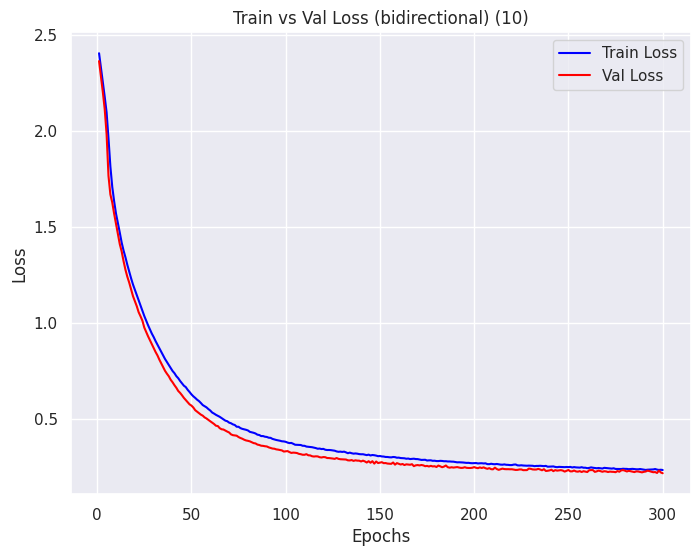

Saved per-epoch loss to: /content/loss/loss_per_epoch_bidirectional_k_fold_10.csv
Saved metrics to: /content/metric/metrics_bidirectional_k_fold_10.csv


In [ ]:
main(directory = '/content/DH604/datasets_16k', model_type = 'bidirectional')

In [ ]:
import shutil
from google.colab import files

folder_name = '/content/scale'
zip_file_name = 'scalars.zip'


shutil.make_archive(zip_file_name.replace('.zip', ''), 'zip', folder_name)

files.download(zip_file_name)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>